In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

import os

if not os.path.isdir('figures'):
    os.makedirs('figures')
if not os.path.isdir('early_stopped'):
    os.makedirs('early_stopped')

In [2]:
# scaler for data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
def plot_loss_and_save(history, batch_size, fold):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('batch_size %s, fold %s model loss'%(batch_size,fold))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'upper right' )
    plt.ylim(0,1)
    plt.savefig('./figures/2A_batch_%s_fold_%s_loss.png'%(batch_size,fold))
    plt.show()

In [4]:
def plot_acc_and_save(history, batch_size, fold):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('batch_size %s, fold % accuracy'%(batch_size,fold))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'lower right' )
    plt.ylim(0,1)
    plt.savefig('./figures/2A_batch_%s_fold_%s_accuracy.png'%(batch_size,fold))
    plt.show()

In [5]:
NUM_CLASSES = 3

epochs = 2000
batch_size = [4,8,16,32,64]
num_neurons = 10
seed = 10

num_attributes = 21
num_folds = 5

weight_decay = 1e-6

np.random.seed(seed)
tf.random.set_seed(seed)

histories={}
performances={}
losses={}

In [6]:
dataset = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X, Y = dataset[1:,:21], dataset[1:,-1].astype(int)
Y = Y - 1 #For python that start from 0

#Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed, shuffle=True)

#Scale based on training set 
X_test = scale(X_test,np.min(X_train,axis = 0),np.max(X_train, axis=0))
X_train = scale(X_train, np.min(X_train, axis = 0),np.max(X_train, axis = 0 ))

In [7]:
#Define K fold
kfold = KFold(n_splits=num_folds,shuffle=True,random_state = seed)

#Define model constructor
def build_model():
    #Model definition
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',input_dim = num_attributes,kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(keras.layers.Dense(NUM_CLASSES, activation ='softmax'))

    #default of sgd is lr = 0.01 so no need specify
    model.compile(optimizer='sgd',
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

In [8]:
for batch_size_idx in batch_size:
    fold = 0
    batch_histories = {}
    model_accuracies = []
    model_losses = []
    
    for train_idx, test_idx in kfold.split(X_train,Y_train):
        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
        fold_csv_logger = keras.callbacks.CSVLogger('./early_stopped/2A_fold_%s_batch_%s_early_stopped.csv' % (fold,batch_size_idx))
        callbacks = [fold_csv_logger, early_stopper]
        #Build model and fit for training, use early stopping to prevent overfitting
        model = build_model()
        batch_histories['fold_%s'%fold] = model.fit(X_train[train_idx],Y_train[train_idx],
                                                   validation_data = (X_train[test_idx],Y_train[test_idx]),
                                                   epochs = epochs,
                                                   verbose = 0,
                                                   batch_size=batch_size_idx,
                                                   callbacks=callbacks)
        
        #plot_acc_and_save(batch_histories['fold_%s'%fold],batch_size_idx,fold)
        #plot_loss_and_save(batch_histories['fold_%s'%fold],batch_size_idx,fold)
        
        #This one is for previously
        #score = model.evaluate(X_train[test_idx],Y_train[test_idx])
        #model_accuracies.append(score[1]*100)
        best_accuracy = max(batch_histories['fold_%s'%fold].history['val_accuracy'])
        best_loss = min(batch_histories['fold_%s'%fold].history['val_loss'])
        
        #Evaluate only by models
        print("Best accuracy of batch_size %s, fold %s: %.4f" %(batch_size_idx,fold,best_accuracy))
        
        model_accuracies.append(best_accuracy*100)
        model_losses.append(best_loss)
        
        fold += 1 #Update fold number
                                                    
    #Update history of this batch_size into main history
    histories['batch_%s_histories'%batch_size_idx]=batch_histories
    #Batch size average performance
    performances['batch_%s'%batch_size_idx]=model_accuracies
    losses['batch_%s'%batch_size_idx]=model_losses
    print("%.2f%% (+/- %.2f%%)" % (np.mean(model_accuracies), np.std(model_accuracies)))
    print("%.4f (+/- %.4f)" % (np.mean(model_losses), np.std(model_losses)))
    #Repeat until all batch_sizes has been evaluated
    

Best accuracy of batch_size 4, fold 0: 0.9027
Best accuracy of batch_size 4, fold 1: 0.9329
Best accuracy of batch_size 4, fold 2: 0.8960
Best accuracy of batch_size 4, fold 3: 0.9091
Best accuracy of batch_size 4, fold 4: 0.8956
90.73% (+/- 1.37%)
0.2388 (+/- 0.0373)
Best accuracy of batch_size 8, fold 0: 0.9027
Best accuracy of batch_size 8, fold 1: 0.9430
Best accuracy of batch_size 8, fold 2: 0.8926
Best accuracy of batch_size 8, fold 3: 0.9057
Best accuracy of batch_size 8, fold 4: 0.9192
91.26% (+/- 1.74%)
0.2328 (+/- 0.0307)
Best accuracy of batch_size 16, fold 0: 0.8960
Best accuracy of batch_size 16, fold 1: 0.9329
Best accuracy of batch_size 16, fold 2: 0.8826
Best accuracy of batch_size 16, fold 3: 0.9057
Best accuracy of batch_size 16, fold 4: 0.8822
89.99% (+/- 1.87%)
0.2527 (+/- 0.0303)
Best accuracy of batch_size 32, fold 0: 0.8993
Best accuracy of batch_size 32, fold 1: 0.9463
Best accuracy of batch_size 32, fold 2: 0.8826
Best accuracy of batch_size 32, fold 3: 0.9024


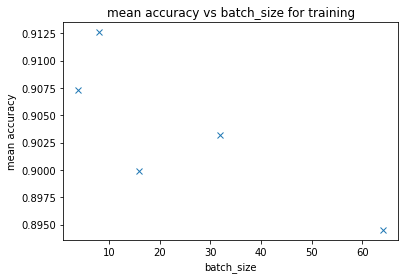

In [19]:
plt.plot(batch_size,[0.9073,0.9126,0.8999,0.9032,0.8945],linestyle='None',marker = 'x')
plt.title('mean accuracy vs batch_size for training')
plt.ylabel('mean accuracy')
plt.xlabel('batch_size')
plt.savefig('./early_stopped/mean_accuracy.png')
plt.show()